### Complete walk-trough of process

In [324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

In [325]:
# Force reload when subsequent execution
import helper_functions
import importlib
importlib.reload(helper_functions)

<module 'helper_functions' from 'C:\\Source\\predicting-house-prices\\helper_functions.py'>

In [6]:
# Loading train and test data
train_df = pd.read_csv('data/train.csv')
print('Loaded %s training rows with %s columns' % (train_df.shape[0], train_df.shape[1]))
test_df = pd.read_csv('data/test.csv')
print('Loaded %s test rows with %s columns' % (test_df.shape[0], test_df.shape[1]))
# This time we train on the complete set
X = train_df.drop('SalePrice', axis=1)
y = train_df['SalePrice']

Loaded 1460 training rows with 81 columns
Loaded 1459 test rows with 80 columns


In [14]:
from sklearn.model_selection import train_test_split

# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

# Create train and test split
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)

In [15]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

# Creating first naive pipeleine for evaluation
pipeline = Pipeline([
    ('univ_select', SelectKBest(k=5)),
    ('lin_reg', linear_model.LinearRegression())
])

In [17]:
# Fitting the model on the training data
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [18]:
# Making prediction on the test set
predictions = pipeline.predict(X_test)

In [19]:
# Cleaning the predictions from 0 and below (temporary step which will be unnecessary later)
predictions[predictions <= 0] = 0

In [20]:
# Print first benchmark of model
print_benchmark(y_test, predictions, log_transform=True)

R2-score: 0.761081041605
RMSE (log): 0.549234845034476


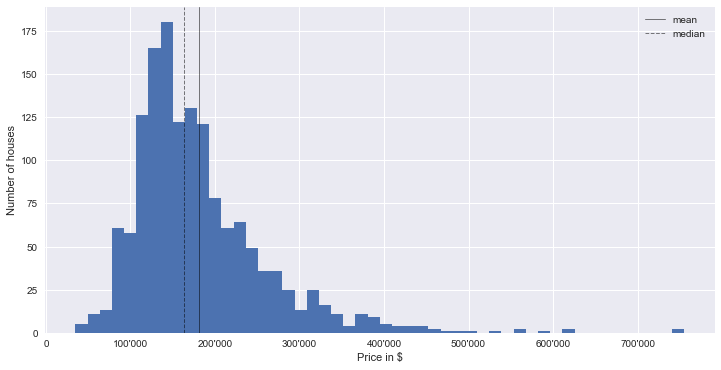

In [78]:
import matplotlib.dates as mdates
import locale
locale.setlocale(locale.LC_ALL, 'de-CH')
thousand_formatter = plt.FuncFormatter(lambda x, _ : locale.format("%d", x, grouping=True))

# We analyze the distribution of target variable SalePrice
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_ylabel('Number of houses')
ax.set_xlabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(train_df['SalePrice'].mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(train_df['SalePrice'].median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(train_df.loc[:, 'SalePrice'], bins=50)
plt.show()

In [37]:
from scipy.stats import skew
skew(train_df.loc[:, 'SalePrice'])

1.880940746034036

In [26]:
# The sale price is heavily right-skewed so we will need to apply a log transform to even the distribution. 
y = np.log1p(y)

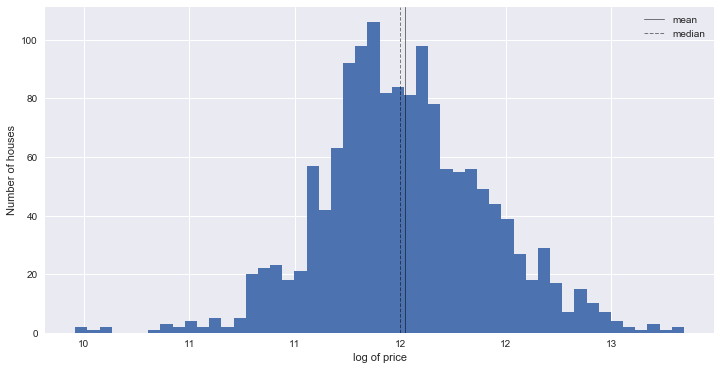

In [79]:
# Evaluate our transformation
fig, ax = plt.subplots(1, figsize=(12, 6))
ax.set_ylabel('Number of houses')
ax.set_xlabel('log of price')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(y.mean(), c='black', linewidth=1, alpha=.5)
ax.axvline(y.median(), c='black', linewidth=1, alpha=.5, linestyle='--')
ax.legend(['mean','median'])
ax.hist(y, bins=50)
plt.show()

In [39]:
# Target variable now has decent skew
skew(y)

0.12122191311528363

In [40]:
# We train the same pipeline as above with the skewed variable
X_train, X_test, y_train, y_test = train_test_split(X_numerical, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [42]:
# And make predictions
predictions = pipeline.predict(X_test)
predictions[predictions <= 0] = 0
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.800512687507
RMSE (log): 0.18438670596266268


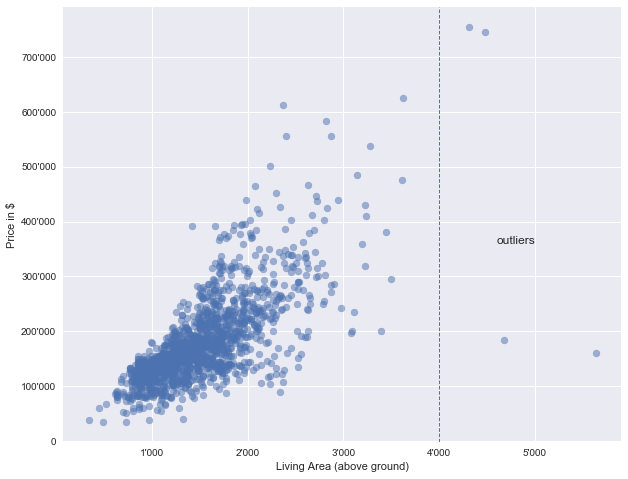

In [53]:
# We explore the data for possible outliers
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.5)
ax.set_xlabel('Living Area (above ground)')
ax.set_ylabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
ax.axvline(4000, linestyle='--', linewidth=1)
ax.text(4600, 360000, 'outliers')
plt.show()

In [55]:
outliers = X[X['GrLivArea'] >= 4000]
print('%s outliers to remove (%s)' % (len(outliers), outliers.index))

4 outliers to remove (Int64Index([523, 691, 1182, 1298], dtype='int64'))


In [56]:
# We now remove the outliers from the data
X = X.drop(outliers.index)
y = y.drop(outliers.index)

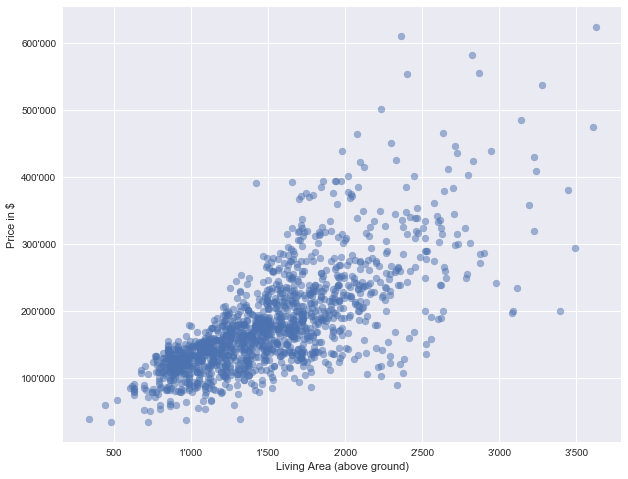

In [67]:
fig, ax = plt.subplots(1, figsize=(10,8))
ax.scatter(X['GrLivArea'], np.expm1(y), alpha=.5)
ax.set_xlabel('Living Area (above ground)')
ax.set_ylabel('Price in $')
ax.yaxis.set_major_formatter(thousand_formatter)
ax.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [76]:
# We remove categorical features first
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

In [77]:
predictions = pipeline.predict(X_numerical)
predictions[predictions <= 0] = 0
print_benchmark(y, predictions, log_transform=False)

R2-score: 0.800862055373
RMSE (log): 0.1766882689892123


In [110]:
# To deepen our standing of the data we explore the directions of the data
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [111]:
# Finde explained variance of the components
pca.explained_variance_ratio_

array([ 0.98371816,  0.0044297 ])

In [112]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

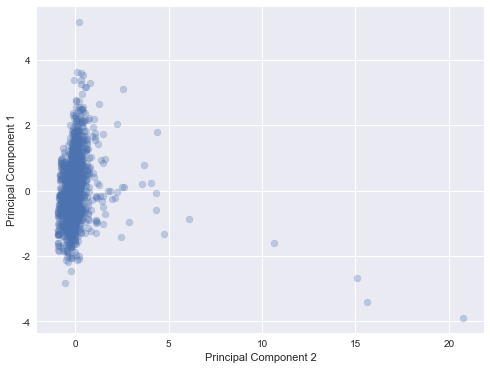

In [123]:
# We visualize the principal components
fig, ax1 = plt.subplots(1, figsize=(8, 6))
ax1.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax1.set_ylabel('Principal Component 1')
ax1.set_xlabel('Principal Component 2')
ax1.yaxis.set_major_formatter(thousand_formatter)
ax1.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [126]:
# Now we apply scaling to the process
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_numerical)
X_numerical = scaler.transform(X_numerical)

In [127]:
from sklearn.decomposition import PCA

# And we repeat the process for the scaled data
pca = PCA(n_components=2, whiten=True)
pca.fit(X_numerical)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [128]:
# Transform the data according to the principal components
transformed_data = pca.transform(X_numerical)

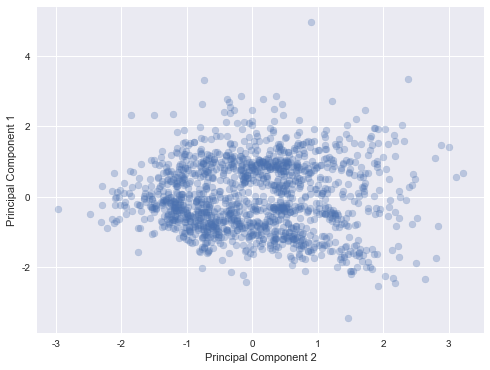

In [129]:
# We visualize the principal components
fig, ax1 = plt.subplots(1, figsize=(8, 6))
ax1.scatter(transformed_data[:,0], transformed_data[:,1], alpha=.3)
ax1.set_ylabel('Principal Component 1')
ax1.set_xlabel('Principal Component 2')
ax1.yaxis.set_major_formatter(thousand_formatter)
ax1.xaxis.set_major_formatter(thousand_formatter)
plt.show()

In [133]:
# We determine the cumluative sum without restriction
pca = PCA(whiten=True)
pca.fit(X_numerical)
cumsum = np.cumsum(pca.explained_variance_ratio_)

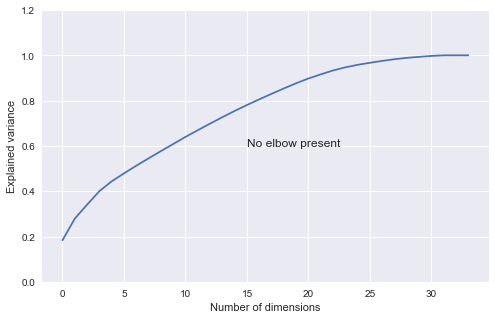

In [134]:
# And  plot the data
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cumsum)
ax.set_xlabel('Number of dimensions')
ax.set_ylabel('Explained variance')
ax.set_ylim(0,1.2)
ax.text(15, .6, 'No elbow present')
plt.show()

In [170]:
# We try how our naive model performs when doing pca
X_numerical = X.select_dtypes(exclude=['object'])

# Remove columns with null values
X_numerical = X_numerical.drop(X_numerical.columns[X_numerical.isnull().any(axis=0)], axis=1)

pca = PCA(whiten=True, n_components=5)
X_reduced = pca.fit_transform(X_numerical)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('univ_select', SelectKBest(k=5, score_func=<function f_classif at 0x00000197F73AC8C8>)), ('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [171]:
predictions = pipeline.predict(X_test)

In [172]:
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.648762860889
RMSE (log): 0.23425324215665486


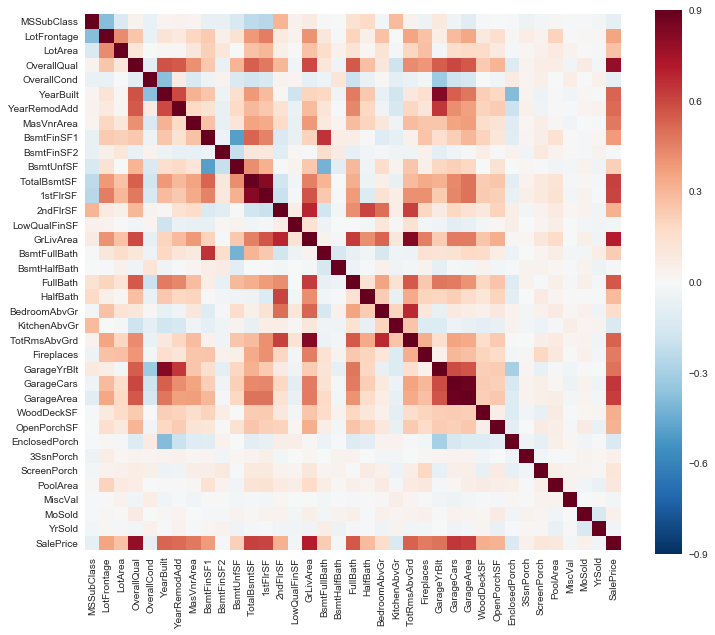

In [175]:
import seaborn as sns

# Next we explore the correlations between the features visually
corrmat = pd.read_csv('data/train.csv').drop(['Id'], axis=1).corr()
plt.subplots(figsize=(12,10))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [202]:
# We find highest correlating features programmatically
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [203]:
X = X.select_dtypes(exclude=['object'])

In [204]:
# Removes redundant feature pairs
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

# Returns the top n correlations
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(X, 10))

Top Absolute Correlations
GarageCars    GarageArea      0.882475
YearBuilt     GarageYrBlt     0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
2ndFlrSF      GrLivArea       0.687501
BedroomAbvGr  TotRmsAbvGrd    0.676620
BsmtFinSF1    BsmtFullBath    0.649212
YearRemodAdd  GarageYrBlt     0.642277
GrLivArea     FullBath        0.630012
2ndFlrSF      TotRmsAbvGrd    0.616423
dtype: float64


In [205]:
# Remove outliers and perform log transform
X, y = prepare_inputs(X, y)

In [221]:
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model

# Now we evaluate how these features to affect our prediction performance
pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('remove_high_correlations', DFTransform(lambda X: X.drop(['GarageCars','TotRmsAbvGrd','2ndFlrSF','TotalBsmtSF'], axis=1))),
    ('lin_reg', linear_model.LinearRegression())
])

In [230]:
# We test performance with these higly correlating features removed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.881869697547
RMSE (log): 0.13585200512095447


In [228]:
# And without the removal of these features
pipeline = Pipeline([
    ('select_numerical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('drop_nans', DFTransform(lambda X: X.drop(X.columns[X.isnull().any(axis=0)], axis=1))),
    ('lin_reg', linear_model.LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)
pipeline.fit(X_train, y_train)

predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, log_transform=False)

R2-score: 0.881869697547
RMSE (log): 0.13585200512095447


In [231]:
# Now handle missing data. First we reload data to eliminate side effects
X = train_df.drop(['Id','SalePrice'], axis=1)
y = train_df['SalePrice']

In [232]:
X, y = prepare_inputs(X, y)

In [233]:
# Which columns do have null values
X.columns[X.isnull().any(axis=0)]

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

In [69]:
# How many null rows in each column
null_columns = X.columns[X.isnull().any()]
X[null_columns].isnull().sum()

LotFrontage      259
Alley           1365
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In [234]:
# First we handle the numerical features with missing values
X_numerical = X.select_dtypes(exclude=['object'])
null_columns = X_numerical.columns[X_numerical.isnull().any()]
X_numerical[null_columns].isnull().sum()

LotFrontage    259
MasVnrArea       8
GarageYrBlt     81
dtype: int64

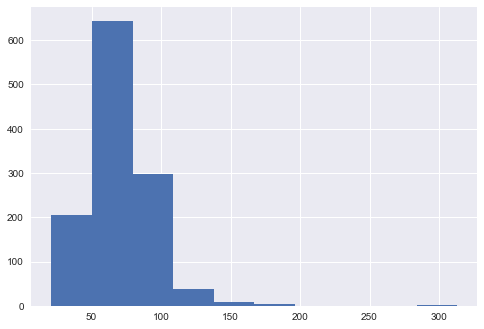

In [71]:
# We start with LotFrontage
X_numerical['LotFrontage'].hist()

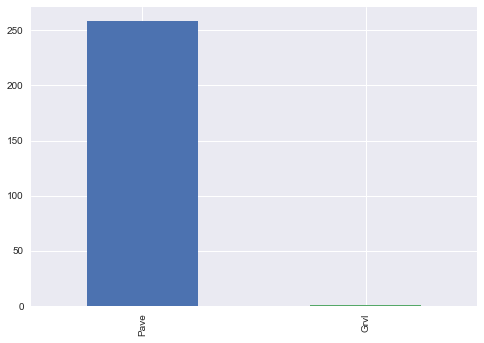

In [235]:
# From the documentation we do not know, why there are NaNs with this features. 
# Because there are small other values we could assume that NaNs means there are no streets connected to this properties.
X[X['LotFrontage'].isnull()]['Street'].value_counts().plot(kind='bar')

In [236]:
# But the road access does suggest, that there are actually streets.
X[X['LotFrontage'].isnull()].corr().abs().iloc[0, :].sort_values(ascending=False).head()

MSSubClass     1.000000
GarageYrBlt    0.300610
YearBuilt      0.277406
2ndFlrSF       0.275932
1stFlrSF       0.244767
Name: MSSubClass, dtype: float64

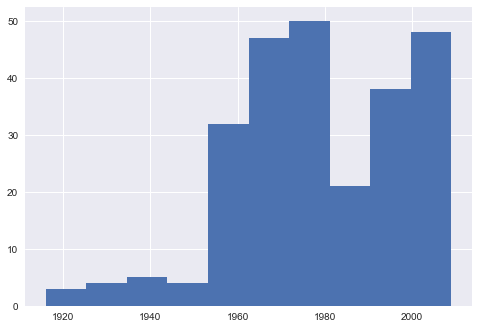

In [238]:
# They also have garages so we will fill in medians in this column
X[X['LotFrontage'].isnull()]['GarageYrBlt'].hist()

In [241]:
# We continue with MasVnrArea
# The NaNs in area are corresponding to the NaNs in type. 
# There are not so many of those and we assume they can be replaced with 0
X[X['MasVnrArea'].isnull()]['MasVnrType'] 

234     NaN
529     NaN
650     NaN
936     NaN
973     NaN
977     NaN
1243    NaN
1278    NaN
Name: MasVnrType, dtype: object

In [244]:
# Next we examine the year the garage was buillt
X[X['GarageYrBlt'].isnull()]['GarageType'].head()

39    NaN
48    NaN
78    NaN
88    NaN
89    NaN
Name: GarageType, dtype: object

In [257]:
# Corresponds with NaNs in type so we can safely assume there is no garage. 
# We replace the values with 0 - so they are even older than the oldest ones.
X_numerical = X.select_dtypes(exclude=['object'])
X_numerical = fill_nans(X_numerical, ['LotFrontage'], ['MasVnrArea', 'GarageYrBlt'])

In [260]:
# The BsmtXXX are coresponding to no basement and can be replaced with 0 
# while the GarageCars are corresponding to no Garage and can also be replaced with 0
'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea'

('BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea')

In [261]:
# Now we cleanup the categoricals
X_categorical = X.select_dtypes(include=['object'])
null_columns = X_categorical.columns[X_categorical.isnull().any()]
X_categorical[null_columns].isnull().sum()

Alley           1365
MasVnrType         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1451
Fence           1176
MiscFeature     1402
dtype: int64

In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans

In [262]:
# These can be cleaned with the pandas function
# In my opinion we need to use both options here, otherwise we loose one dimension if there are no nans
pd.get_dummies(X_categorical, dummy_na=True, drop_first=True).head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MSZoning_nan,Street_Pave,Street_nan,Alley_Pave,Alley_nan,LotShape_IR2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
2,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


In [346]:
# Now we have built a helper function and we separate
# transformation and prediction pipelines
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda x: fill_numerical_nans(x))),
    ('encode_dummies', DFTransform(lambda x: create_dummies(x)))
])

In [344]:
pipeline = Pipeline([
    ('lin_reg', LinearRegression())
])

In [348]:
# Now we evaluate our model with the encoded variables
(trans_p, fit_p, _) = train_pipeline(trans_pipeline, pipeline, show_plot=False)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 287)
Create train/test split
Create predictions...(train)
R2-score: 0.956370687386
RMSE (log): 0.08254248626350628
Create predictions...(test)
R2-score: 0.882556838871
RMSE (log): 0.13545631633507443
Fitting the pipeline to all the data...
Score: 0.94784228


In [356]:
# This did not help our model a lot. We need to handle ordinal values first.
# We encode the ordinal features with a label encoder after we did some cleaning
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
])

In [357]:
# Now we evaluate our model with the encoded variables
(trans_p, fit_p, _) = train_pipeline(trans_pipeline, pipeline, show_plot=False)

Loading training data...
Transforming input...
There are still NaNs in the data!
Index(['Utilities'], dtype='object')
Creating dummies...
Starting with input of shape: (2915, 79)
Returning output of shape: (2915, 221)
Create train/test split
Create predictions...(train)
R2-score: 0.950934519959
RMSE (log): 0.08753392184103406
Create predictions...(test)
R2-score: 0.884098845793
RMSE (log): 0.13456411991043715
Fitting the pipeline to all the data...
Score: 0.94160933


In [63]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [82]:
pipeline = Pipeline([
    ('lin_reg', LinearRegression())
])

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [66]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [67]:
predictions = pipeline.predict(X_test)

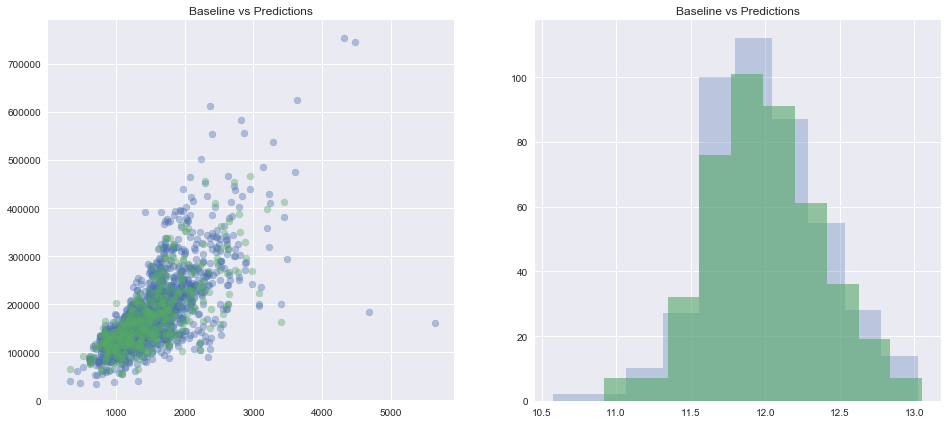

R2-score: 0.867192915026
RMSE (log): 0.1403652639948691


In [68]:
plot_benchmark(X_test, y_test, predictions)

Make the predictions for the test set. But first we want to train on the whole set without train and test split

In [69]:
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)
X = trans_pipeline.fit_transform(X)
pipeline.fit(X, y)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [70]:
test_df = pd.read_csv('data/test.csv')
X = test_df.drop(['Id'], axis=1)
X = trans_pipeline.transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1459, 79)
Returning output of shape: (1459, 288)


In [71]:
predictions = pipeline.predict(X)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 157335.28
Difference in means is: -23585.9177049
IMPORTANT: There is something wrong with your predictions!!!


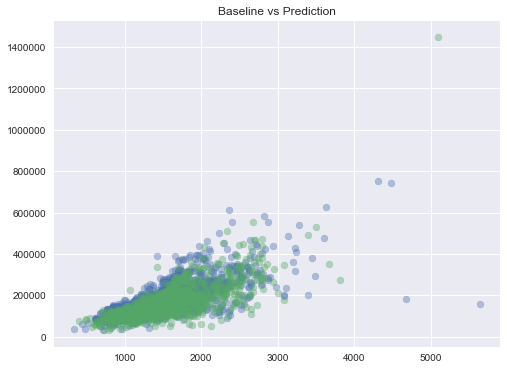

In [73]:
draw_sanity_check(predictions, False)

In [27]:
write_submission(test_df, np.expm1(predictions))

File written to C:\Source\predicting-house-prices\submissions\20180721204847.csv


Kaggle score: 0.21469

### Building a better pipeline with cross validation

In [98]:
def rsme_log(y_actual, y_predicted):
    return math.sqrt(mean_squared_error(y_actual, y_predicted))

In [22]:
from sklearn.metrics import make_scorer

In [92]:
train_df = pd.read_csv('data/train.csv')
X = train_df.drop(['SalePrice','Id'], axis=1)
y = train_df['SalePrice']
X, y = prepare_inputs(X, y)

In [93]:
X = trans_pipeline.fit_transform(X)

Filling numerical nans...
Creating dummies...
Starting with input of shape: (1456, 79)
Returning output of shape: (1456, 288)


In [100]:
from sklearn.cross_validation import cross_val_score
scorer = make_scorer(rsme_log)
cross_val_score(pipeline, X, y, cv=5, scoring=scorer)

array([ 0.12468363,  0.13696554,  0.14420381,  0.10996149,  0.12675848])

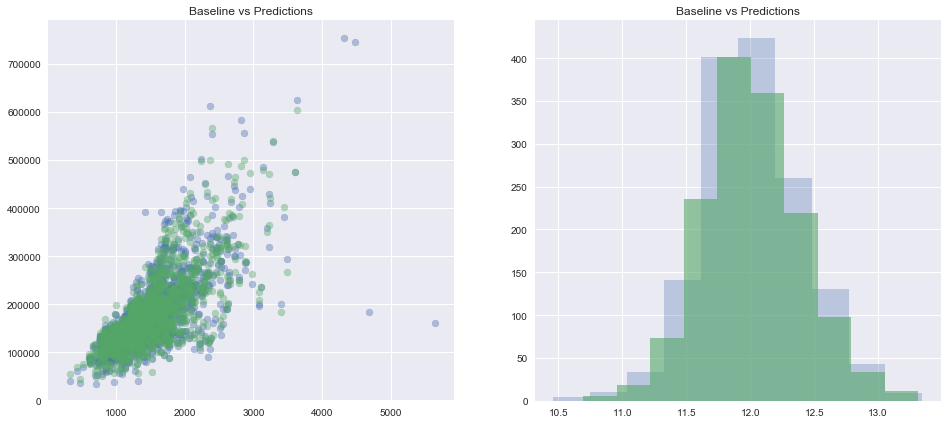

R2-score: 0.947845293788
RMSE (log): 0.0904226972302732


In [101]:
pipeline.fit(X, y)
predictions = pipeline.predict(X)
plot_benchmark(X, y, predictions)

This naturally is overfitted because we have done no split. But cross validation does not help us very much.

### Optimizing our dummy variable converter and using LabelEncoder

Some special cases of our categorical features need to be handles first

In [1]:
# moved to helper functions

Ordinal features need to be converted with label encoder

In [16]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
])

### Changing to transform all data at once - only way this can work

In [465]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)

In [466]:
X_train, y_train = prepare_inputs(X_train, y_train)
X_train.shape

(1456, 79)

In [467]:
X_combined = pd.concat((X_train, X_test)).reset_index(drop=True) 

In [468]:
X_tranformed = trans_pipeline.fit_transform(X_combined)

Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)


In [469]:
X_train_trans = X_tranformed[:X_train.shape[0]] 
X_test_trans = X_tranformed[X_train.shape[0]:]

In [470]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)

In [471]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('lin_reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [472]:
predictions = pipeline.predict(X_test)

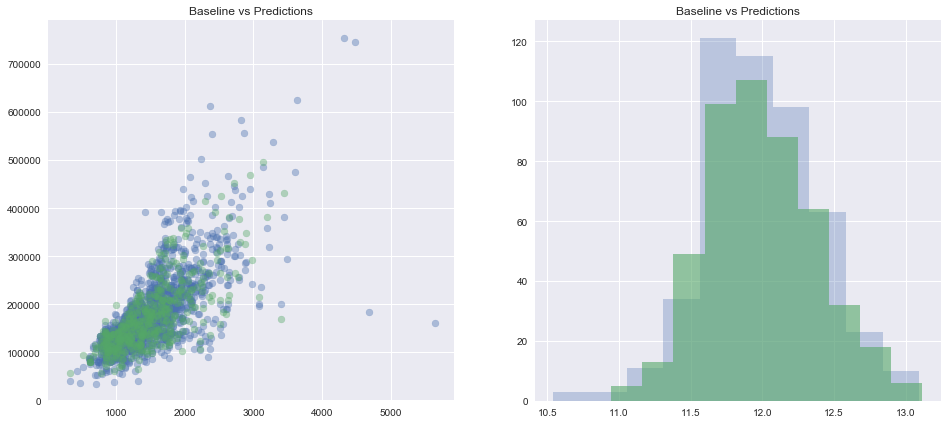

R2-score: 0.883987658729
RMSE (log): 0.1346286499098431


In [473]:
plot_benchmark(X_test, y_test, predictions)

### Automating pipeline, training, prediction and submission

In [3]:
def prepare_inputs(X_val, y_val):
    outliers = X_val[X_val['GrLivArea'] >= 4000]
    return (X_val.drop(outliers.index), np.log1p(y_val.drop(outliers.index)))

In [10]:
(trans_p, fit_p, _) = train_pipeline(Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ]), 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

NameError: name 'LinearRegression' is not defined

And now also make a method for the execution of the pipeline:

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179437.58
Difference in means is: -1483.61339445


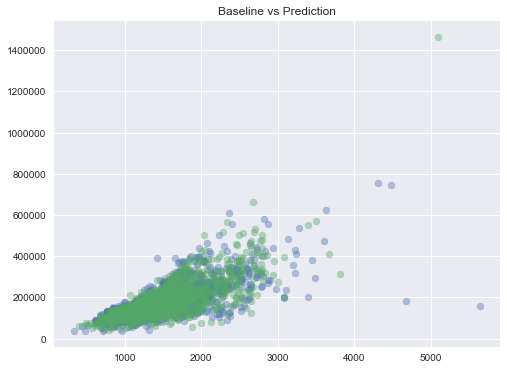

In [491]:
predictions = execute_pipeline(trans_p, fit_p, X_test_trans)

In [492]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180722135957.csv


Kaggle score: 0.13133

The kaggle score does match very well to our local score though there are some signs of possible overfitting (0.95 to 0.88 R2-Score). We want to explore this closer.

### Explore possible overfitting

In [6]:
seaborn.set()

def plot_learning_curve(transformation_pipeline, estimation_pipeline):
    train_df =  pd.read_csv('data/train.csv')
    X_train = train_df.drop(['SalePrice','Id'], axis=1)
    y_train = train_df['SalePrice']
    X_test = pd.read_csv('data/test.csv').drop(['Id'], axis=1)
    X_train, y_train = prepare_inputs(X_train, y_train)
    X_train_trans = transformation_pipeline.fit_transform(X_train)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_trans, y_train, test_size=.33, random_state=42)
    
    
    train_errors, val_errors = [],[]
    for m in range(1, len(X_train)):
        estimation_pipeline.fit(X_train[:m], y_train[:m])
        y_train_predict = estimation_pipeline.predict(X_train[:m])
        y_valid_predict = estimation_pipeline.predict(X_valid)
        
        train_errors.append(math.sqrt(mean_squared_error(y_train_predict, y_train[:m])))
        val_errors.append(math.sqrt(mean_squared_error(y_valid_predict, y_valid)))
    
    fig, ax = plt.subplots(1, figsize=(10, 7))
    ax.plot(train_errors)
    ax.plot(val_errors)
    ax.set_xlabel('training size')
    ax.set_ylabel('RMSE (log)')
    ax.set_ylim([0, 1])
    plt.title('Training curve')
    plt.legend(['training', 'validation'])
    plt.show()
    print_benchmark(y_valid, y_valid_predict)

In [17]:
trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

In [ ]:
plot_learning_curve(trans_pipeline, 
    Pipeline([
    ('lin_reg', LinearRegression())
]))

The plot is not clear at the moment. The curves are pretty close but not to close and the error is got but can be improved. The validation curve seems to have potential but we did not see any polynomial correlations in our model. We try another model to compare.

### Ridge Regression - Closed Form Method - l2 method

Ridge regression allows us to do regularization. We explore regularization with a grid search.

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


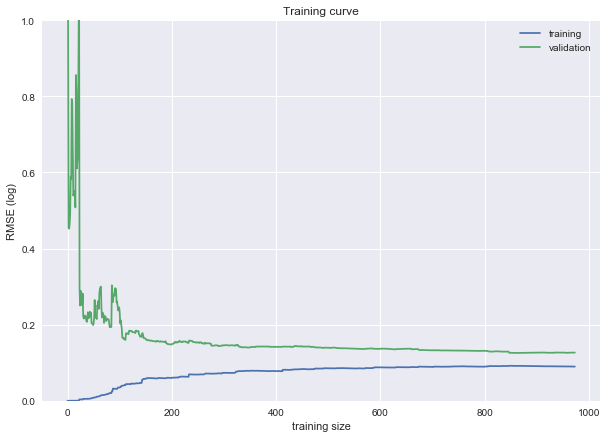

R2-score: 0.897419732704
RMSE (log): 0.12659522006263185


In [547]:
from sklearn.linear_model import Ridge

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('ridge_regression', Ridge(alpha=1, solver='cholesky'))
]))

Result is a little bit better. We try to use grid search here.

In [4]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ridge_regression', Ridge(solver='cholesky'))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

NameError: name 'prepare_inputs' is not defined

In [566]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


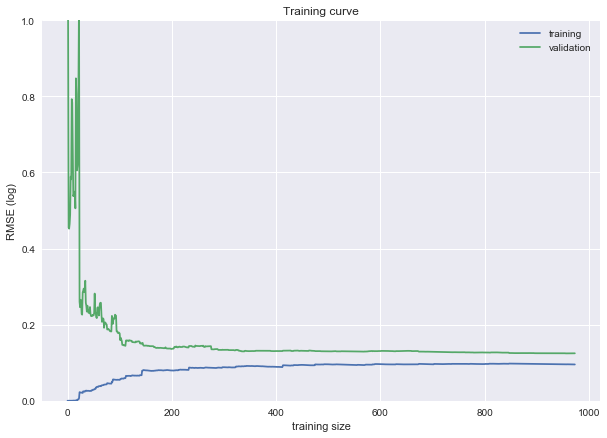

R2-score: 0.900470661643
RMSE (log): 0.1246984207500989


In [567]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.941804551552
RMSE (log): 0.09533071939950581
Create predictions...(test)


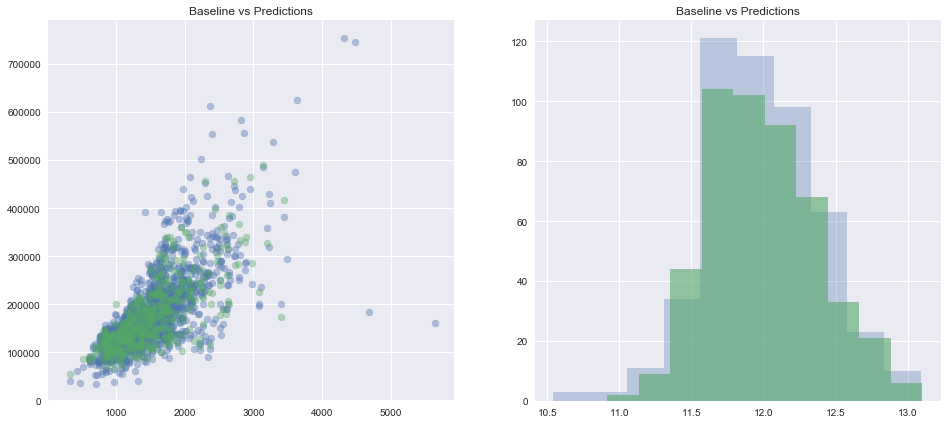

R2-score: 0.900409068211
RMSE (log): 0.12473699940409354
Fitting the pipeline to all the data...
Score: 0.93452305


In [570]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179206.01
Difference in means is: -1715.18196257


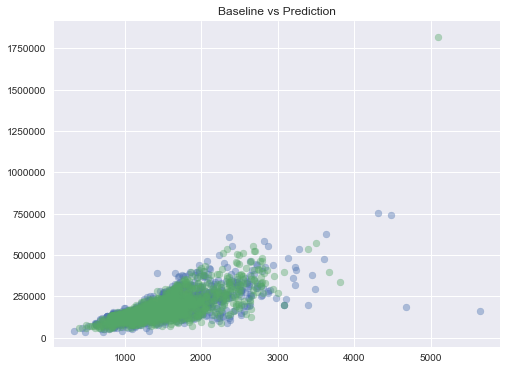

In [571]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [572]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180722165430.csv


Kaggle score: 0.12114

The reqularization has had some impact and the score improved. We can now try other models.

### Stochastic Gradient Descent - Non closed

In [575]:
from sklearn.model_selection import GridSearchCV    
from sklearn.linear_model import SGDRegressor

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'sgd_regression__penalty': ['l1', 'l2', 'elasticnet']}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('sgd_regression', SGDRegressor(penalty='l2'))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train.ravel())

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('sgd_regression', SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=5, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sgd_regression__penalty': ['l1', 'l2', 'elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


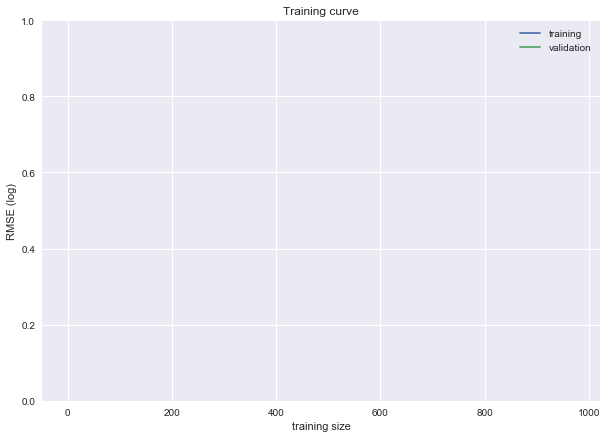

R2-score: -2.33298079594e+34
RMSE (log): 6.037275253511089e+16


In [576]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

No meaningful result. We skip this algorithm. Maybe there are to few samples - see sklearn diagram

### Lasso regression - l1 method

Uses l1 regularization instead of l2. Lets wee what this will bring. We also use grid search.

In [584]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False]}

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('lasso_regression', Lasso(alpha=1))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Lets see what the best parameter is.

In [586]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [ ]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Result with l1 (lasso) is even a little bit better than with ridge. But the result is small.

Because lasso is sensitive to outliers, we also try the algorithm with a scaling before. For this we use add the RobustScaler to our pipeline.

In [591]:
import warnings
warnings.simplefilter("once")

from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False],
              'robust_scaler__with_scaling' : [True, False],
              'robust_scaler__with_centering' : [True, False]
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('robust_scaler', RobustScaler()),
        ('lasso_regression', Lasso(alpha=1))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False], 'robust_scaler__with_scaling': [True, False], 'robust_scaler__with_centering': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [592]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('robust_scaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,
       with_scaling=False)), ('lasso_regression', Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

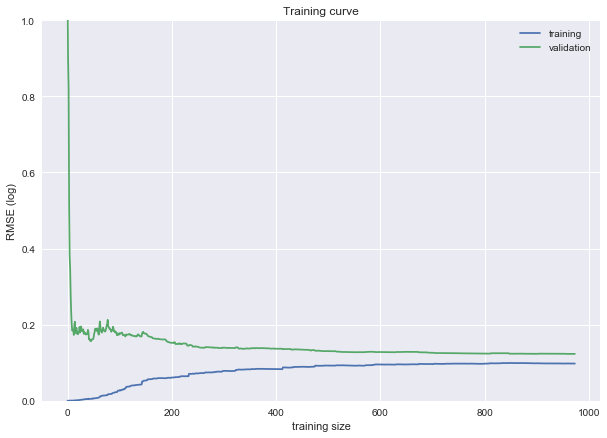

R2-score: 0.902889222068
RMSE (log): 0.12317401881733071


In [593]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

The robust scaler did not bring anything good. Maybe the normalize did the same thing as well. So we remove the robust scaler again and make a submission. We also try to increase the number of iterations.

In [597]:
from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import RobustScaler

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'lasso_regression__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
              'lasso_regression__normalize' : [True, False]
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('lasso_regression', Lasso(alpha=1, max_iter=3000))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('lasso_regression', Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=3000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lasso_regression__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10], 'lasso_regression__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


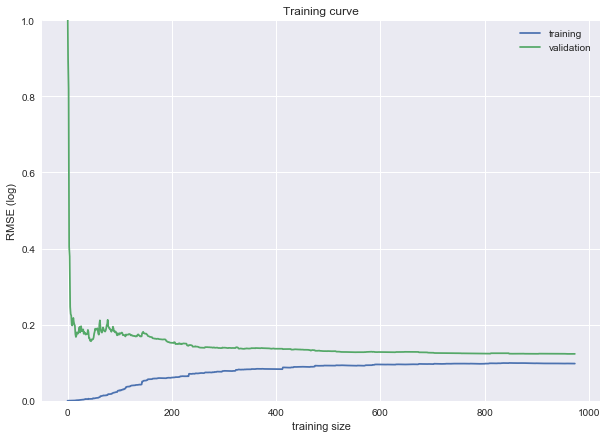

R2-score: 0.902889222068
RMSE (log): 0.12317401881733071


In [598]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.93891519239
RMSE (log): 0.09766860078185423
Create predictions...(test)


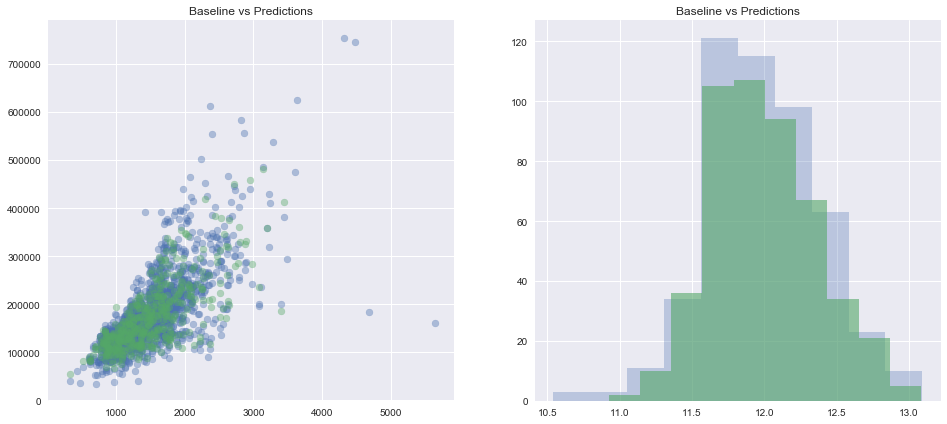

R2-score: 0.902818299725
RMSE (log): 0.12321898908624954
Fitting the pipeline to all the data...
Score: 0.92834489


In [599]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178491.16
Difference in means is: -2430.03523266


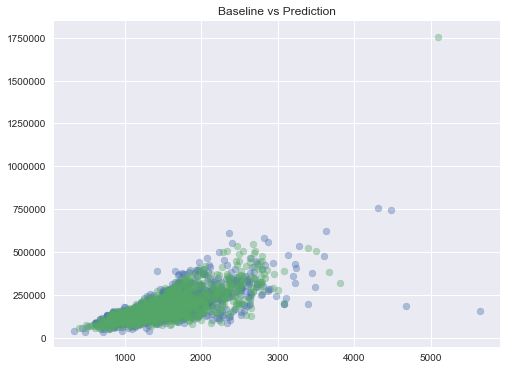

In [600]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [601]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728095727.csv


Kaggle score: 0.12391

### Elastic net

Middle ground between lasso (l1) and ridge (l2). We try this just for fun.

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

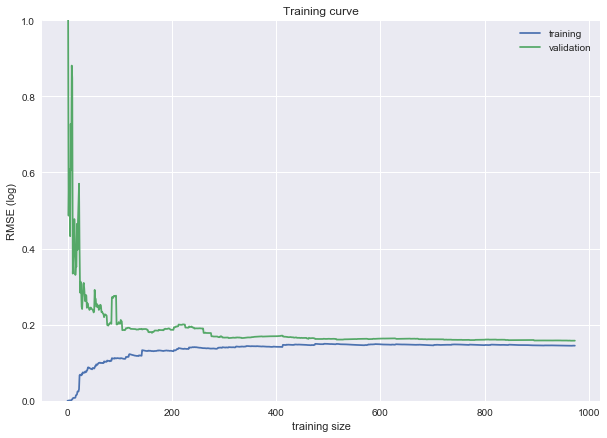

R2-score: 0.840347985351
RMSE (log): 0.15793289506830857


In [602]:
from sklearn.linear_model import ElasticNet

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('elasticnet', ElasticNet(alpha=.1, l1_ratio=.5))
]))

Result is not good. We try to do a grid search over the parameters.

In [605]:
from sklearn.model_selection import GridSearchCV       

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {'elasticnet__alpha': [0.001, 0.01, 0.1, 1],
             'elasticnet__l1_ratio': [0.25, 0.5, 0.75],
             'elasticnet__normalize': [True, False]}
     
def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('elasticnet', ElasticNet())
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('elasticnet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'elasticnet__alpha': [0.001, 0.01, 0.1, 1], 'elasticnet__l1_ratio': [0.25, 0.5, 0.75], 'elasticnet__normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increa

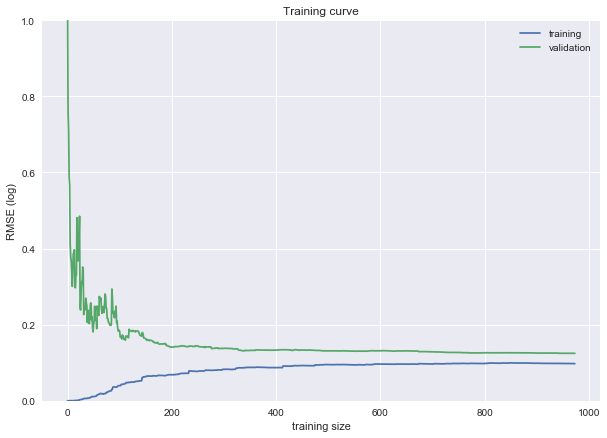

R2-score: 0.900577208273
RMSE (log): 0.12463165775138761


In [606]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Result is close to other learners. I think we need to try some another method

### DescisionTreeRegressor

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


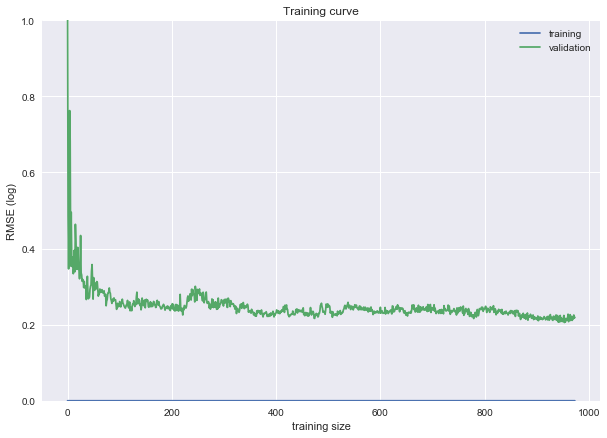

R2-score: 0.692126624989
RMSE (log): 0.21931657810170838


In [607]:
from sklearn.tree import DecisionTreeRegressor

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('tree_regressor', DecisionTreeRegressor(random_state=42))
]))

Shure, a heavy overfitting. We need to reduce the min samples per leaf.

In [609]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
        'tree_regressor__min_samples_leaf': [1, 2, 4, 10, 20, 50],
        'tree_regressor__criterion': ['mse', 'friedman_mse', 'mae'],
        'tree_regressor__splitter': ['best','random'],
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
        ('tree_regressor', DecisionTreeRegressor(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tree_regressor', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tree_regressor__min_samples_leaf': [1, 2, 4, 10, 20, 50], 'tree_regressor__criterion': ['mse', 'friedman_mse', 'mae'], 'tree_regressor__splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [610]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('tree_regressor', DecisionTreeRegressor(criterion='friedman_mse', max_depth=None,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best'))])

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


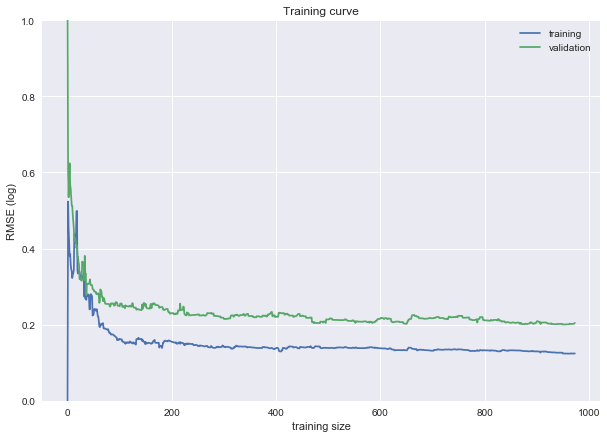

R2-score: 0.732087311113
RMSE (log): 0.20458888546065387


In [611]:
plot_learning_curve(trans_pipeline, 
    estimator.best_estimator_)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.901198607792
RMSE (log): 0.12421381281994101
Create predictions...(test)


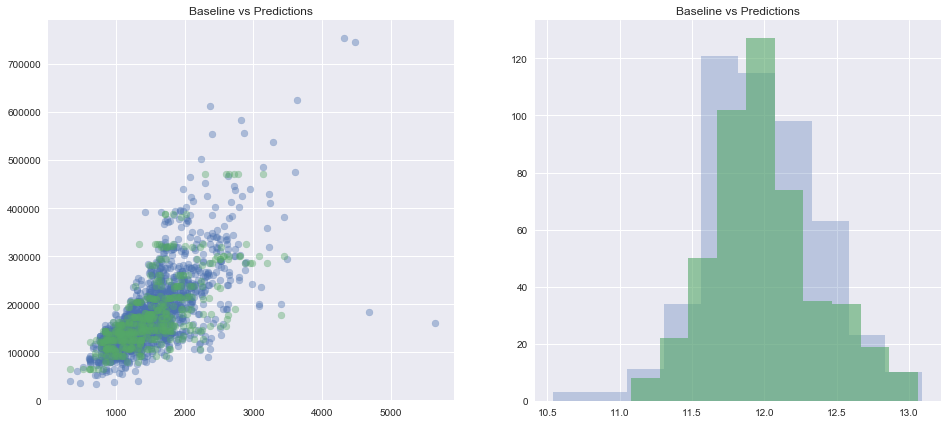

R2-score: 0.732087346958
RMSE (log): 0.20458887177437393
Fitting the pipeline to all the data...
Score: 0.90353883


In [612]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_)

A decision tree regressor is performing substantially weaker than the earlier regressors.

### Optimization 1: Introducing Bagging 

Best learner so far is ridge regression. But we did not use normalization nor did we do a good grid search. So we do this again before we apply a bagging algorithm.

In [613]:

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'ridge_regression__fit_intercept': [True, False],
    'ridge_regression__normalize': [True, False],
    'ridge_regression__fit_intercept': [True, False],
    'ridge_regression__solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ridge_regression', Ridge(random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.034284054894927e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.0095932817066929e-16
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 8.733987949710132e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. 

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge_regression__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 'ridge_regression__fit_intercept': [True, False], 'ridge_regression__normalize': [True, False], 'ridge_regression__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [614]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ridge_regression', Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='svd', tol=0.001))])

In [626]:
from sklearn.ensemble import BaggingRegressor

bag_estimator = BaggingRegressor(
        estimator.best_estimator_, n_estimators=500,
        max_samples=200, bootstrap=True, n_jobs=4
)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.92775011867
RMSE (log): 0.10622015476098734
Create predictions...(test)


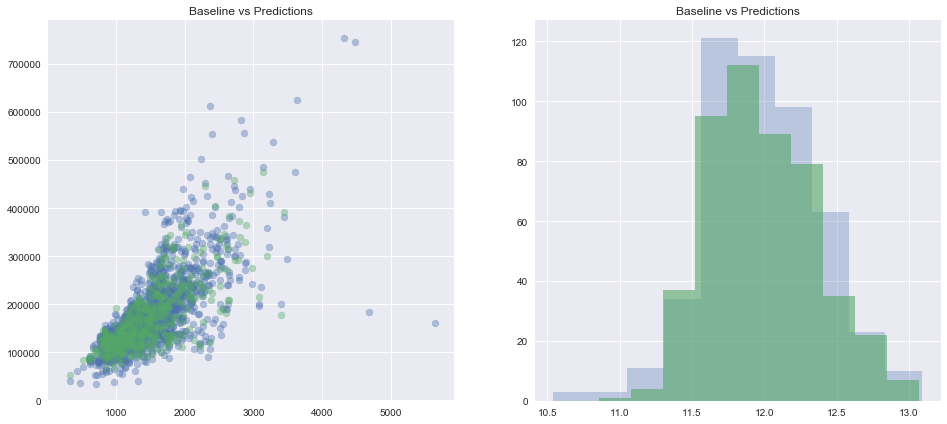

R2-score: 0.901308983171
RMSE (log): 0.12417215166133377
Fitting the pipeline to all the data...
Score: 0.91947691


In [627]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    bag_estimator)

The result is not really better, but we can try how this does score on the kaggle set.

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 178982.35
Difference in means is: -1938.84801958


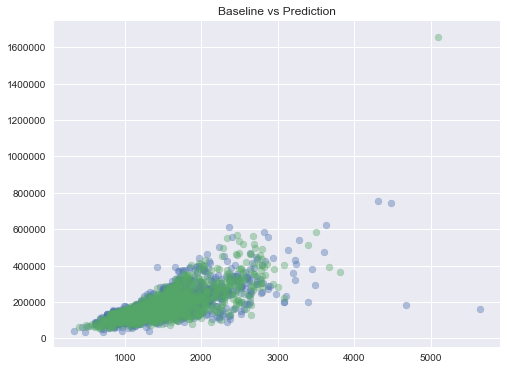

In [628]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [629]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728113947.csv


Kaggle: 0.12484

We try to weaken the 'weak' learner and see how this is performing.

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.927723619149
RMSE (log): 0.10623963247585456
Create predictions...(test)


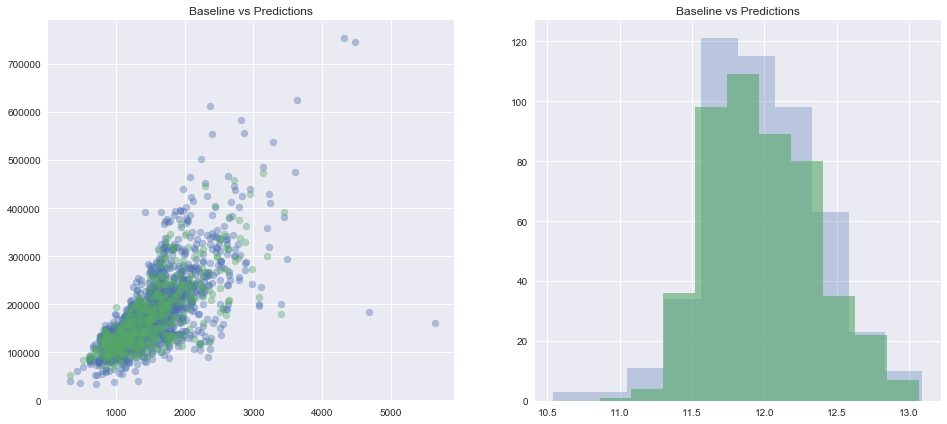

R2-score: 0.901727267342
RMSE (log): 0.12390873155526672
Fitting the pipeline to all the data...
Score: 0.92002241


In [634]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
        BaggingRegressor(
        Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,random_state=42), 
            n_estimators=500, max_samples=200, bootstrap=True, n_jobs=4))

Bagging was no help at all. The learners are probably not week enough to achieve better results when combining.

We try a RandomForestRegressor which basically does the bagging within

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


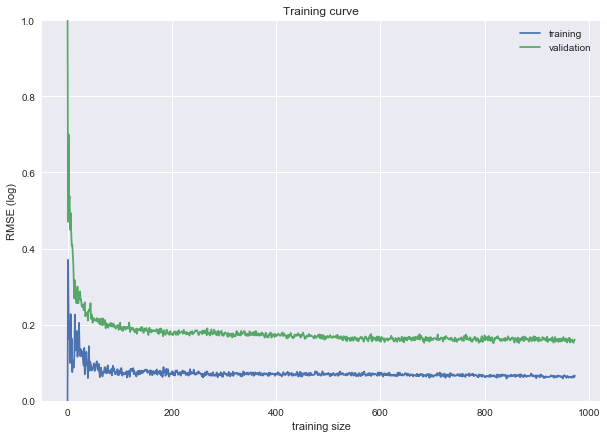

R2-score: 0.834692165029
RMSE (log): 0.16070600824929887


In [636]:
from sklearn.ensemble import RandomForestRegressor

plot_learning_curve(trans_pipeline, 
    Pipeline([
        ('random_forest', RandomForestRegressor(n_estimators=10))
]))

Naturally we have a very heavy overfitting when only 10 estimators are taken and the min_numbers_split is not set which defaults to 1.

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

In [33]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'random_forest__criterion': ['mse','mae'],
    'random_forest__oob_score': [True, False],
}
    
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('random_forest', RandomForestRegressor(n_estimators=50))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('random_forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_forest__criterion': ['mse', 'mae'], 'random_forest__oob_score': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [34]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('random_forest', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False))])

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.983537657797
RMSE (log): 0.050703060344946774
Create predictions...(test)


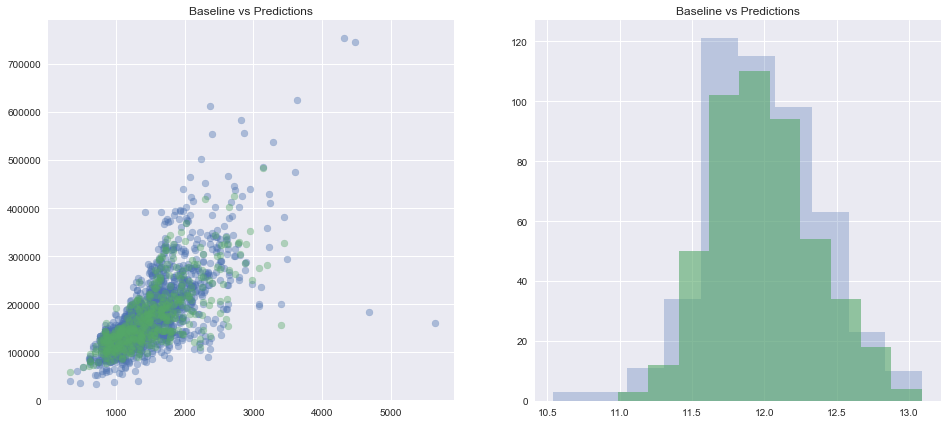

R2-score: 0.856583400175
RMSE (log): 0.14968735203496278
Fitting the pipeline to all the data...
Score: 0.98381411


In [36]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=True, random_state=None, verbose=0, warm_start=False))

Random forest does also not yield better results. It bascially is a bagging mechanism and we did expect something like this.

### Optimization 2: Boosting

Bagging was not very successful so we try boosting as another ensemble method. We try two different boosting method here: AdaBoost and XGBoost (kaggle winner here and there)

In [41]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
    'ada_boost__loss': ['linear', 'square', 'exponential']
}
     
scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('ada_boost', AdaBoostRegressor(
                                    base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
                                       normalize=False, random_state=42, solver='cholesky', tol=0.001),
                                    n_estimators=100))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ada_boost__loss': ['linear', 'square', 'exponential']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

In [42]:
estimator.best_estimator_

Pipeline(memory=None,
     steps=[('ada_boost', AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=None))])

The best loss function seams to be linear. How to interpret? Don't know. Let see what this brings. It did not bring any good so we are experimenting with learning_rate.

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.942494151866
RMSE (log): 0.09476421455353426
Create predictions...(test)


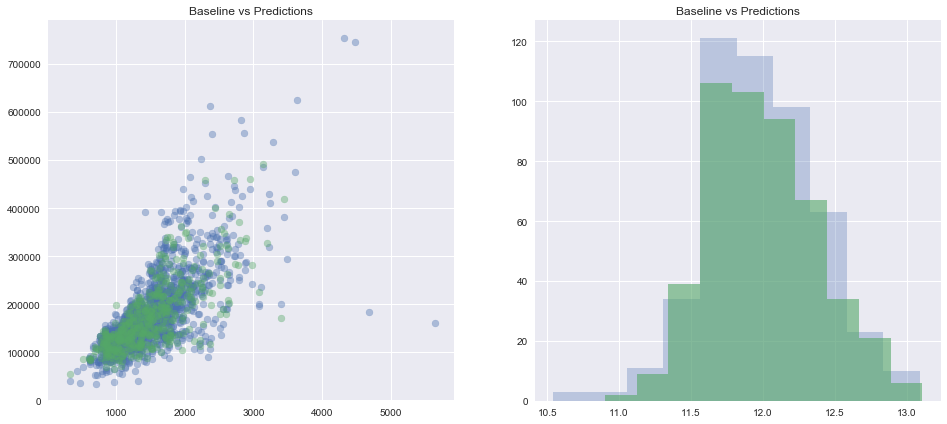

R2-score: 0.901579318728
RMSE (log): 0.12400196815347336
Fitting the pipeline to all the data...
Score: 0.93509998


In [56]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    AdaBoostRegressor(base_estimator=Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='cholesky', tol=0.001),
         learning_rate=.001, loss='linear', n_estimators=100,
         random_state=42))

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 179180.63
Difference in means is: -1740.56648916


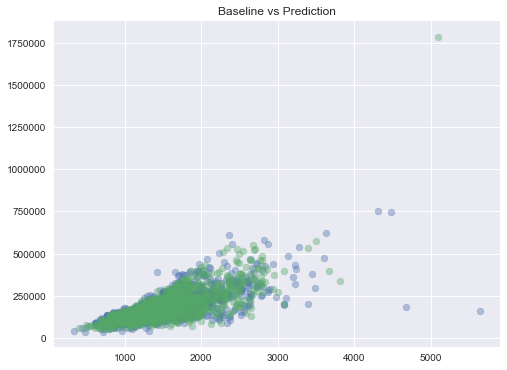

In [57]:
predictions = execute_pipeline(trans_p, fit_p, X_transformed)

In [58]:
write_submission(predictions, False)

File written to C:\Source\predicting-house-prices\submissions\20180728143142.csv


Kaggle score: 0.12088

We try gradient boosting as well before tryig xgboost:

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.943812534362
RMSE (log): 0.09367163107514748
Create predictions...(test)


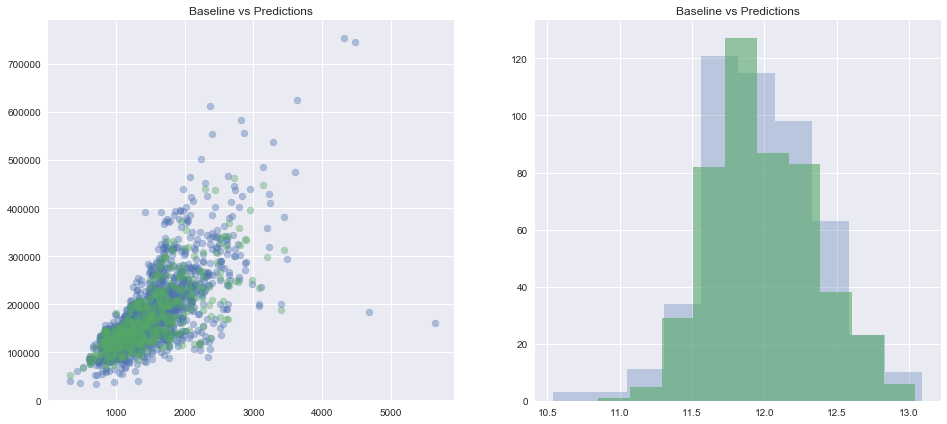

R2-score: 0.891282534094
RMSE (log): 0.13032719714679042
Fitting the pipeline to all the data...
Score: 0.92672761


In [72]:
from sklearn.ensemble import GradientBoostingRegressor

(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    GradientBoostingRegressor(max_depth=2, n_estimators=1000, learning_rate=.01, warm_start=True))

No parameters did bring better results. I think we should try an algorithm which is not from sklearn to compare results.

#### Non sklearn learning

In [78]:
import xgboost as xgb

In [85]:
xgb.XGBRegressor().get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

In [88]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

param_dict = {
                'xgboost__booster': ['gbtree', 'gblinear','dart'],
                'xgboost__learning_rate': [.1, .3, .9],
                'xgboost__gamma': [0, 1, 10, 20],
                'xgboost__max_depth': [1, 3, 6],
                'xgboost__subsample': [.2, .4, .6],
             }

scorer = make_scorer(rmse_score, greater_is_better=False)
estimator = GridSearchCV(Pipeline([
                    ('xgboost', xgb.XGBRegressor(n_estimators=50, random_state=42))
            ]), param_dict, scoring=scorer)
estimator.fit(X_train, y_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('xgboost', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'xgboost__booster': ['gbtree', 'gblinear', 'dart'], 'xgboost__learning_rate': [0.1, 0.3, 0.9], 'xgboost__gamma': [0, 1, 10, 20], 'xgboost__max_depth': [1, 3, 6], 'xgboost__subsample': [0.2, 0.4, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmse_score, greater_is_better=False), verbose=0)

Loading training data...
Transforming input...
Creating dummies...
Starting with input of shape: (2915, 78)
Returning output of shape: (2915, 219)
Create train/test split
Create predictions...(train)
R2-score: 0.965045764124
RMSE (log): 0.07339962648146511
Create predictions...(test)


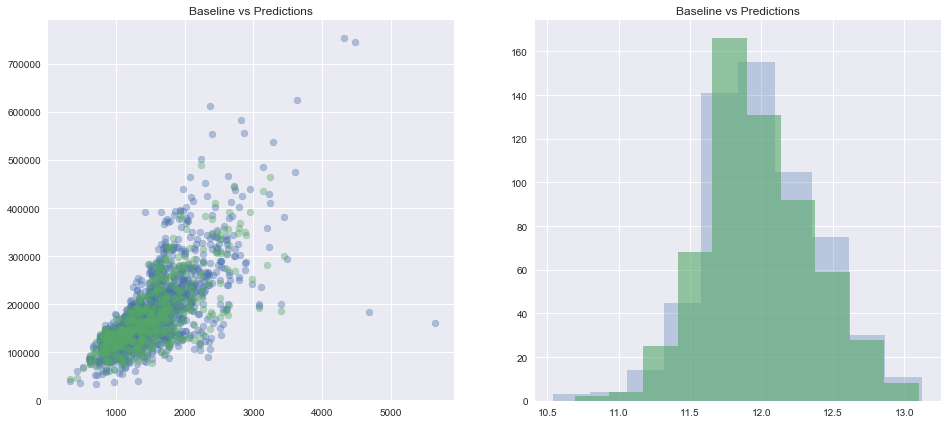

R2-score: 0.888841486359
RMSE (log): 0.1332962190219232
Fitting the pipeline to all the data...
Score: 0.95117544


In [92]:
(trans_p, fit_p, X_transformed) = train_pipeline(trans_pipeline, 
    estimator.best_estimator_, size_test=.4)

Does not behave any better than the sklearn ensembles. We try another algorithm class altogether.

### Optimization 3: Neural Net

In [12]:
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed


In [35]:
import helper_functions

In [45]:
import importlib
importlib.reload(helper_functions)
from helper_functions import *

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from helper_functions import *

%matplotlib inline
seaborn.set()

import helper_functions

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline, FeatureUnion, _transform_one
from sklearn.externals.joblib import Parallel, delayed

class NoFitMixin:
    def fit(self, X, y=None):
        return self

# class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
class DFTransform(BaseEstimator, TransformerMixin, NoFitMixin):
    def __init__(self, func, copy=False):
        self.func = func
        self.copy = copy

    def transform(self, X):
        X_ = X if not self.copy else X.copy()
        return self.func(X_)
        from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer

def rmse_score(y_t, y_pred):
    return math.sqrt(mean_squared_error(y_t, y_pred))

trans_pipeline = Pipeline([
    ('impute_numerical', DFTransform(lambda X: fill_numerical_nans(X))),
    ('impute_categorical', DFTransform(lambda X: impute_categorical(X))),
    ('impute_special_cases', DFTransform(lambda X: impute_special_cases(X))),
    ('drop_features', DFTransform(lambda X: drop_features(X))),
    ('ordinal_features', DFTransform(lambda X: encode_ordinals(X))),
    ('check_nans', DFTransform(lambda X: check_nans(X))),
    ('encode_dummies', DFTransform(lambda X: create_dummies(X)))
    ])

Define network

In [203]:
import numpy as np
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
def build_nn():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.2))
    model.add(Dense(110, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the model
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [204]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


In [205]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=42)

In [206]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint  
import livelossplot as lp

plot_callback = lp.PlotLossesKeras()
callbacks = [plot_callback] #, checkpointer]

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn, batch_size=5, epochs=500, callbacks=callbacks, 
                                     validation_data=(X_test, y_test)))
])

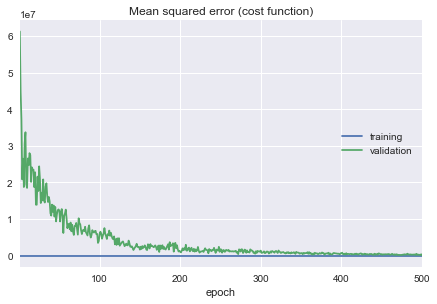

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp_regressor', <keras.wrappers.scikit_learn.KerasRegressor object at 0x0000025E440E8400>)])

In [207]:
pipeline.fit(X_train, y_train)

In [208]:
predictions = pipeline.predict(X_test)

Mean of Salesprice in Training-Data: 180921.20
Mean of Salesprice in predictions: 162965.34
Difference in means is: -17955.8521404


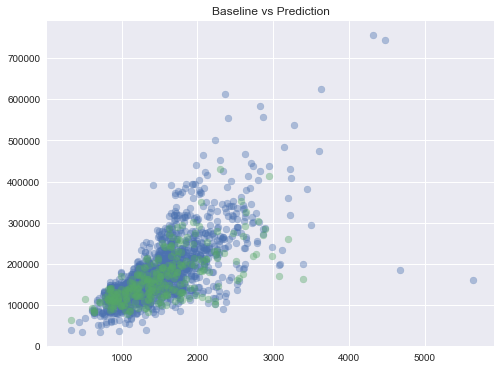

In [210]:
pred = np.expm1(predictions)
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
fig, ax = plt.subplots(1, figsize=(8, 6), sharey=True)
ax.scatter(train_df['GrLivArea'], train_df['SalePrice'], alpha=.4)
ax.set_title('Baseline vs Prediction')
#ax.set_ylim(0, 1000000)
ax.scatter(X_test['GrLivArea'], pred, alpha=.4)
print('Mean of Salesprice in Training-Data: %.2f' % train_df['SalePrice'].mean())
print('Mean of Salesprice in predictions: %.2f' % pred.mean())
difference = pred.mean() - train_df['SalePrice'].mean()
print('Difference in means is: %s' % difference)

In [211]:
print_benchmark(y_test, predictions, False)

R2-score: 0.836023803499
RMSE (log): 0.16092902206605617


The crossvalidation is probably not right (the graph above). But this does not trouble us !!. We just try another model.

In [557]:
train_df =  pd.read_csv('data/train.csv')
X_train = train_df.drop(['SalePrice','Id'], axis=1)
y_train = train_df['SalePrice']
X_train, y_train = prepare_inputs(X_train, y_train)

X_train = trans_pipeline.fit_transform(X_train)

Creating dummies...
Starting with input of shape: (1456, 78)
Returning output of shape: (1456, 219)


In [558]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.25, random_state=42)

In [559]:
def build_nn2():
    model = Sequential()
    model.add(Dense(219, kernel_initializer='normal', activation='relu', input_shape=(219,)))
    model.add(Dropout(.3))
    model.add(Dense(100, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.2))
    model.add(Dense(50, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(.1))
    model.add(Dense(1, kernel_initializer='normal', activation='relu'))

    # Compiling the mode
    model.compile(loss = 'mean_squared_error', optimizer='adam')
    return model

In [560]:
X_transformed = StandardScaler().fit_transform(X_test)

In [561]:
import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [562]:
from keras.callbacks import History 
#model_history = LossHistory()

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp_regressor', KerasRegressor(build_fn=build_nn2, batch_size=5, epochs=1000, verbose=1, 
                                     callbacks=[plot_callback],  validation_data=(X_transformed, y_test)))
])

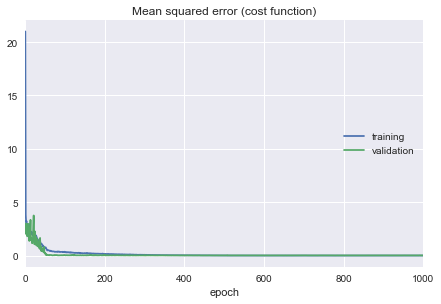

In [563]:
model_info = pipeline.fit(X_train, y_train)

In [555]:
def plot_model_history(model_history, epochs):
    fig, axs = plt.subplots(1,figsize=(15,5))
    # summarize history for loss
    axs.plot(range(1,len(model_history['loss'])+1),model_history['loss'])
    axs.plot(range(1,len(model_history['val_loss'])+1),model_history['val_loss'])
    axs.set_title('Model Loss')
    axs.set_ylabel('Loss')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(1,len(model_history['loss'])+1),len(model_history['loss'])/epochs)
    axs.legend(['train', 'val'], loc='best')
    plt.show()

In [564]:
predictions = pipeline.predict(X_test)
print_benchmark(y_test, predictions, False)

364/364 [==============================] - 2s 6ms/step
R2-score: 0.843160699743
RMSE (log): 0.15515935816447401


The model is not very good but was still improving in the end.